In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib
#%matplotlib notebook
%matplotlib inline
from matplotlib import pyplot as plt

import seaborn as sns

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0) # bigger figure!


sns.set() # better looking figs


In [2]:
# our own set of small helper functions for plotting, etc
from utils import plot_embedding, plot_compare_embeddings, show_heatmap, plot_confusion_matrix

In [3]:
df = pd.read_csv("questionnaire-answers-per-clip.csv")
constructs=df.T.iloc[7:].T.columns
df

,Unnamed: 0,clipName,pptID,condition,gettingOnWell,relationshipBetweenCharacters,workingTogether,leftDominant,rightDominant,leftCooperative,...,leftFearful,rightFearful,leftSad,rightSad,leftContent,rightContent,leftAngry,rightAngry,leftAmused,rightAmused
0,0,1Laugh1PushAway,55,4,0.0,0.0,0.0,4.0,4.0,4.0,...,3.0,4.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0
1,1,1Laugh1PushAway,87,4,1.0,0.0,2.0,0.0,4.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,3.0,1.0
2,2,1Laugh1PushAway,118,2,0.0,0.0,0.0,1.0,3.0,4.0,...,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,4.0,3.0
3,3,1Laugh1PushAway,136,2,2.0,0.0,2.0,1.0,3.0,1.0,...,2.0,1.0,2.0,2.0,1.0,1.0,1.0,3.0,2.0,2.0
4,4,1Laugh1PushAway,417,4,2.0,2.0,2.0,2.0,3.0,1.0,...,2.0,2.0,2.0,2.0,3.0,1.0,1.0,3.0,3.0,1.0
5,5,1Laugh1PushAway,681,4,1.0,1.0,2.0,1.0,3.0,1.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,4.0,2.0
6,6,1Laugh1PushAway,695,4,0.0,0.0,1.0,3.0,3.0,2.0,...,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,4.0,3.0
7,7,1Laugh1PushAway,1031,4,2.0,2.0,2.0,0.0,4.0,3.0,...,0.0,0.0,0.0,0.0,2.0,2.0,0.0,4.0,3.0,1.0
8,8,1Laugh1PushAway,1315,4,1.0,0.0,0.0,0.0,4.0,0.0,...,3.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,3.0,1.0
9,9,1Laugh1PushAway,1460,2,0.0,0.0,0.0,2.0,2.0,4.0,...,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,4.0,4.0


*we define here several useful partial views of the main dataframe*

In [4]:
fullscene_df=df[df["condition"]==4] # full scene

# the responses to the 22 Likert-scale questions
fullscene_ratings_df=fullscene_df.T.iloc[7:].T.astype(float)
fullscene=fullscene_ratings_df.values # the underlying numpy array

# clip names
fullscene_labels=fullscene_df["clipName"].values

# mean ratings per clip
fullscene_means=fullscene_df.groupby(["clipName"]).mean().T.iloc[6:].T


skel_df=df[df["condition"]==2] # skeleton

# the responses to the 22 Likert-scale questions
skel_ratings_df=skel_df.T.iloc[7:].T.astype(float)
skel=skel_ratings_df.values # the underlying numpy array

# clip names
skel_labels=skel_df["clipName"].values

# mean ratings per clip
skel_means=skel_df.groupby(["clipName"]).mean().T.iloc[6:].T

# Latent constructs

The first step of the analysis looks at latent constructs.

Our initial data contains responses to 22 questions (ie, 22 degrees of freedom). The question is: can those 22 DoFs be grouped into a smaller number of *latent* constructs that would effectively encapsulate the differences observed in the reponses between video clips.

Three approaches are explored:
- Principal component analysis (PCA)
- Principal component analysis (purely for dimensionality reduction) followed by a linear discriminant analysis (LDA) that aims at maximising inter-class distances (ie, inter-clips ratings) while minimizing intra-class distances (ie, the differences between ratings for a given clip).
- Explorative Factor Analysis (EFA)

## PCA

In [5]:
from sklearn.decomposition import PCA

We compute the PCA transformation with the responses to the *fullscene* stimuli.

We then project both the *fullscene* and the *skeletal-only* responses in this PCA space, effectively reducing the dimensionality of our data from 22 to `nb_components` (ie, 6).

In [6]:
nb_components = 6

fullscene_pca_model=PCA(n_components=nb_components).fit(fullscene)

fullscene_pca = fullscene_pca_model.transform(fullscene)
fullscene_means_pca = fullscene_pca_model.transform(fullscene_means.values)

skel_pca_model = fullscene_pca_model

skel_pca = skel_pca_model.transform(skel)
skel_means_pca = skel_pca_model.transform(skel_means.values)

With 6 components, about 70% of the variance in the *fullscene* dataset is explained.

Cumulative explained variance: [0.25259011 0.41081217 0.52573506 0.59399419 0.64685227 0.69016467]


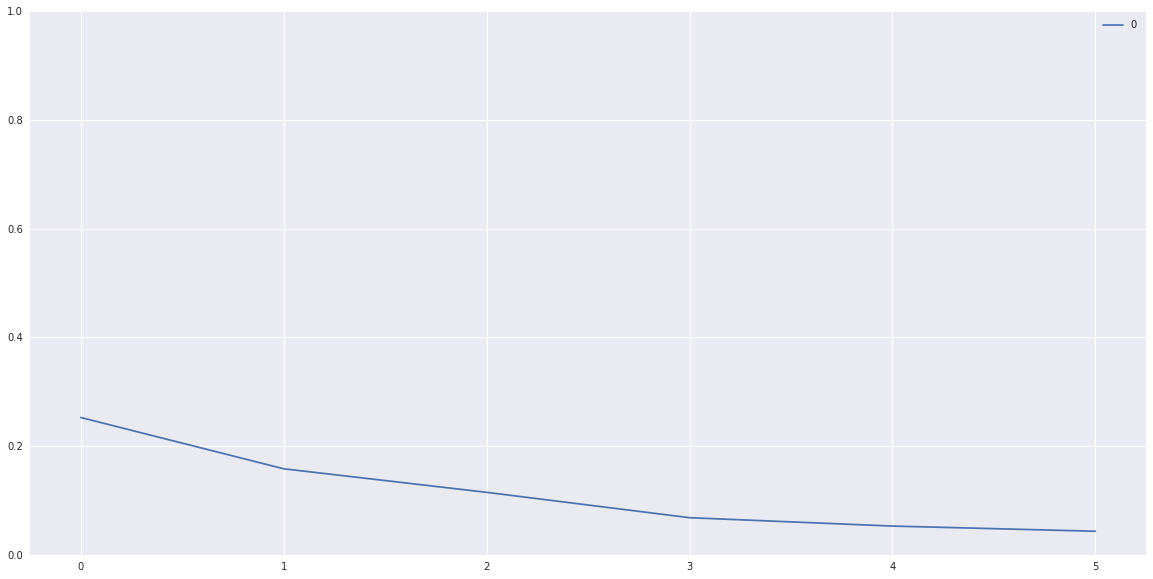

In [7]:
pd.DataFrame(fullscene_pca_model.explained_variance_ratio_).plot(ylim=[0,1])
print("Cumulative explained variance: %s" % fullscene_pca_model.explained_variance_ratio_.cumsum())

### Plotting of the embeding

`plot_embedding` plots each questionnaire's response when projected along the first 2 eigenvectors. Responses' colours correspond to the clips.

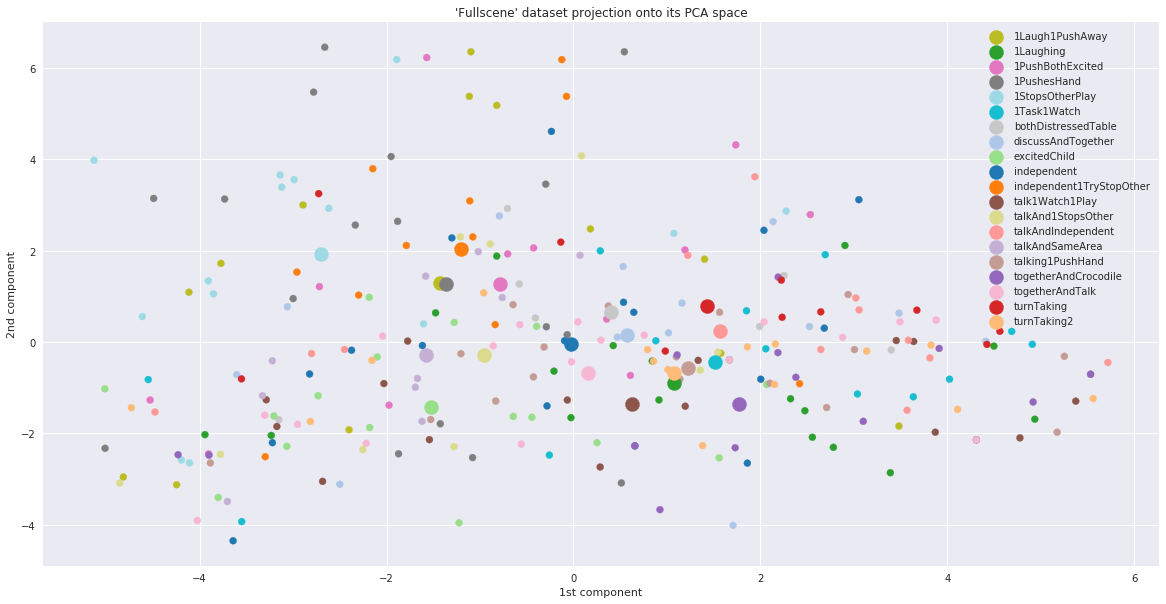

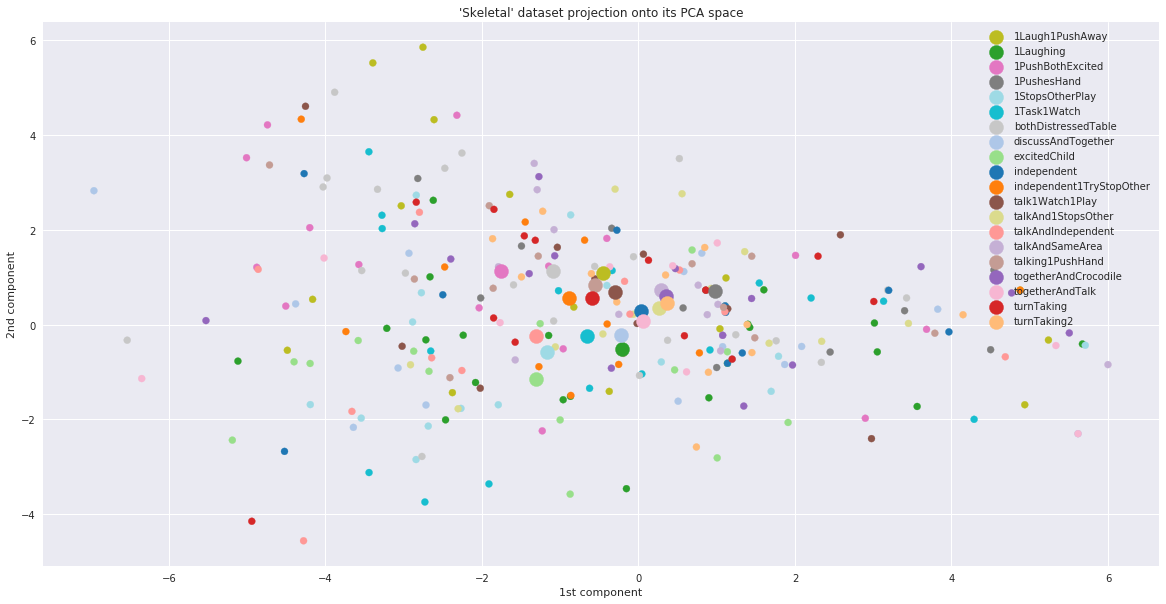

In [8]:
plot_embedding(fullscene_pca, fullscene_labels, fullscene_means_pca, fullscene_means.index, title="'Fullscene' dataset projection onto its PCA space", three_d=False)
plot_embedding(skel_pca, skel_labels, skel_means_pca, skel_means.index, title="'Skeletal' dataset projection onto its PCA space", three_d=False) 

For each clip, we can then plot the distance between its embedding based on fullscene ratings vs its embedding based on skeletal data only.

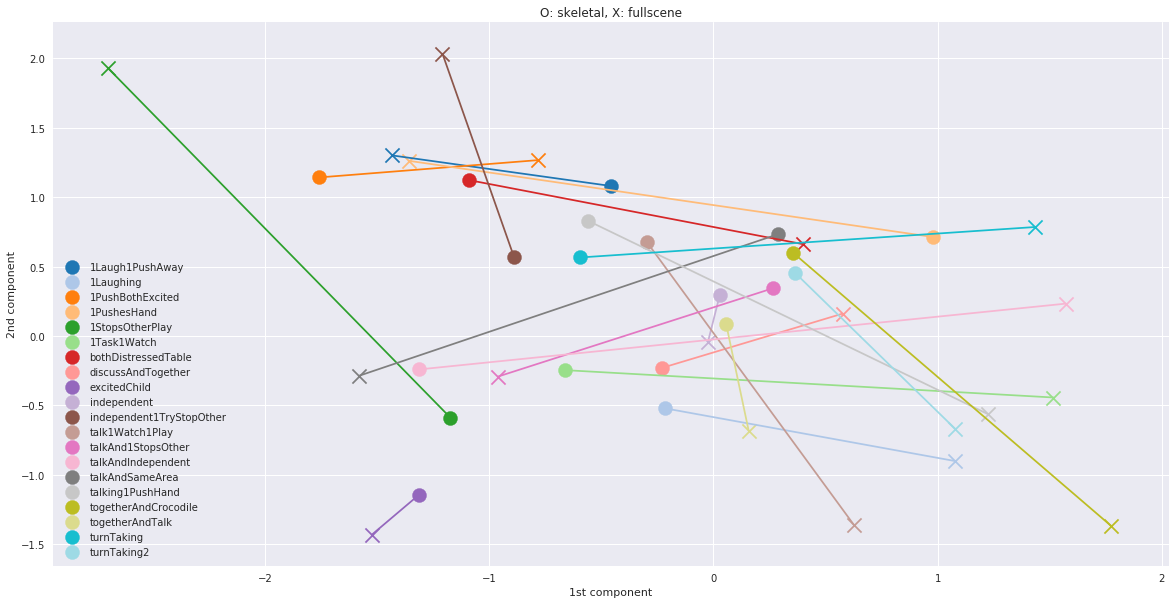

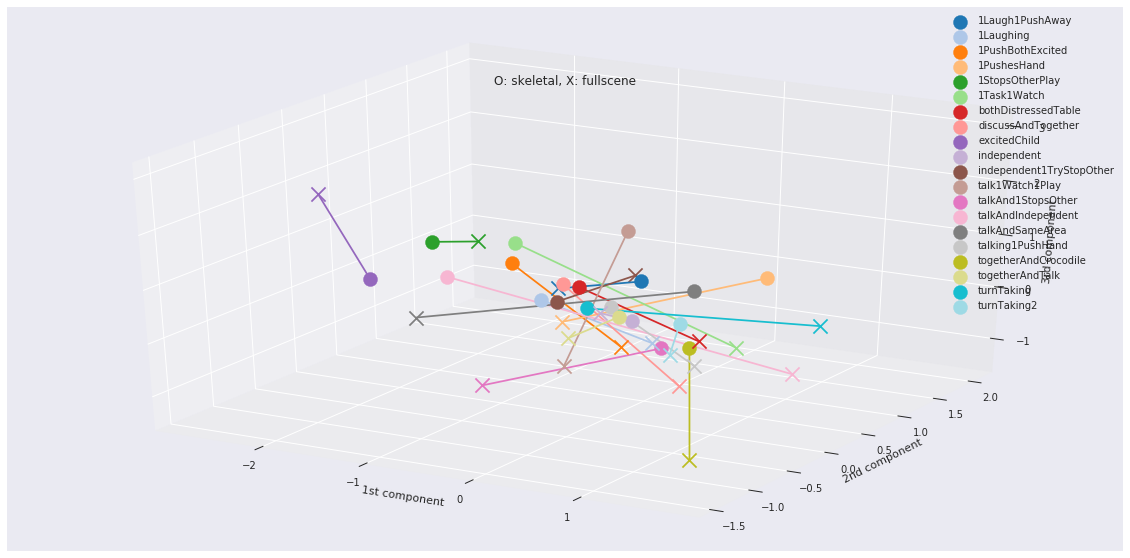

In [9]:
plot_compare_embeddings(skel_means_pca, fullscene_means_pca, skel_means.index, title="O: skeletal, X: fullscene", three_d=False)
plot_compare_embeddings(skel_means_pca, fullscene_means_pca, skel_means.index, title="O: skeletal, X: fullscene", three_d=True)

Computing the actual distance between clips in the two conditions shows that they are generally quite far apart. A straightforward PCA embedding does not seem to be effective to evidence similarities between our 2 conditions.

In [10]:
distances_pca=pd.DataFrame(np.power(np.sum(np.power(skel_means_pca - fullscene_means_pca, 2), axis=1), 0.5), index=skel_means.index, columns=["distance_pca"])
show_heatmap(distances_pca, cmap="summer_r")

,distance_pca
clipName,
1Laugh1PushAway,1.92953
1Laughing,1.49327
1PushBothExcited,2.20443
1PushesHand,3.19782
1StopsOtherPlay,3.65733
1Task1Watch,2.79491
bothDistressedTable,2.42239
discussAndTogether,2.33071
excitedChild,1.72344


To answer the question: *does a PCA evidence common latent factors between our 2 conditions?*, we compute a PCA model *based on the skeletal data*, and compare the resulting PCA components with the ones found with the fullscene data.

We observe that the resulting loadings look very different.

In [11]:
# plot of PCA components, with fullscene vs skeleton components side-by-side


skel_pca_model=PCA(n_components=nb_components).fit(skel)

skel_pca = skel_pca_model.transform(skel)
skel_means_pca = skel_pca_model.transform(skel_means.values)

skel_pca_components = pd.DataFrame(skel_pca_model.components_,columns=constructs).T
fullscene_pca_components = pd.DataFrame(fullscene_pca_model.components_,columns=constructs).T

# merge PCA components into one dataframe, skel and fullscene side-by-side
pca_components=pd.concat([skel_pca_components, fullscene_pca_components], keys=["skel", "fullscene"], axis=1)
pca_components=pca_components.swaplevel(0,1,1).sort_index(1)


show_heatmap(pca_components[abs(pca_components)>0.2])


/usr/lib/python3/dist-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


## LDA

We perform the LDA *on top of the PCA* as LDA typically requires O > 3 F, with O the nb of observations and F the nb of features (here, we have ~26 observations for originally 22 questions). Using the PCA as a dimensionality reduction tool, we bring down the number of degrees of freedom to 6.

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

nb_components = 4

fullscene_lda_model = LinearDiscriminantAnalysis(n_components=nb_components, solver='svd')
fullscene_lda_model.fit(fullscene_pca, fullscene_labels)

fullscene_lda = fullscene_lda_model.transform(fullscene_pca_model.transform(fullscene))
fullscene_means_lda = fullscene_lda_model.transform(fullscene_pca_model.transform(fullscene_means.values))

skel_lda = fullscene_lda_model.transform(fullscene_pca_model.transform(skel))
skel_means_lda = fullscene_lda_model.transform(fullscene_pca_model.transform(skel_means.values))

Attention: the variance explained by the LDA transformation is the variance in the *PCA* space, not in the original 22-D space of the questionnaire!

In [13]:
print("Cumulative explained variance: %s" % fullscene_lda_model.explained_variance_ratio_.cumsum())

Cumulative explained variance: [0.50330235 0.75785615 0.8679825  0.93441839]


When projected in the PDA space, the clips in condition *skeleton* vs *fullscene* are much closer to one another.

In [14]:
distances_lda=pd.DataFrame(np.power(np.sum(np.power(skel_means_lda - fullscene_means_lda, 2), axis=1), 0.5), index=skel_means.index, columns=["distance_lda"])

distances = pd.concat([distances_pca, distances_lda], axis=1)
show_heatmap(distances, cmap="summer_r")


,distance_pca,distance_lda
clipName,,
1Laugh1PushAway,1.92953,1.39128
1Laughing,1.49327,0.699011
1PushBothExcited,2.20443,1.12945
1PushesHand,3.19782,1.7543
1StopsOtherPlay,3.65733,2.28616
1Task1Watch,2.79491,1.56624
bothDistressedTable,2.42239,1.51713
discussAndTogether,2.33071,1.45519
excitedChild,1.72344,1.09196


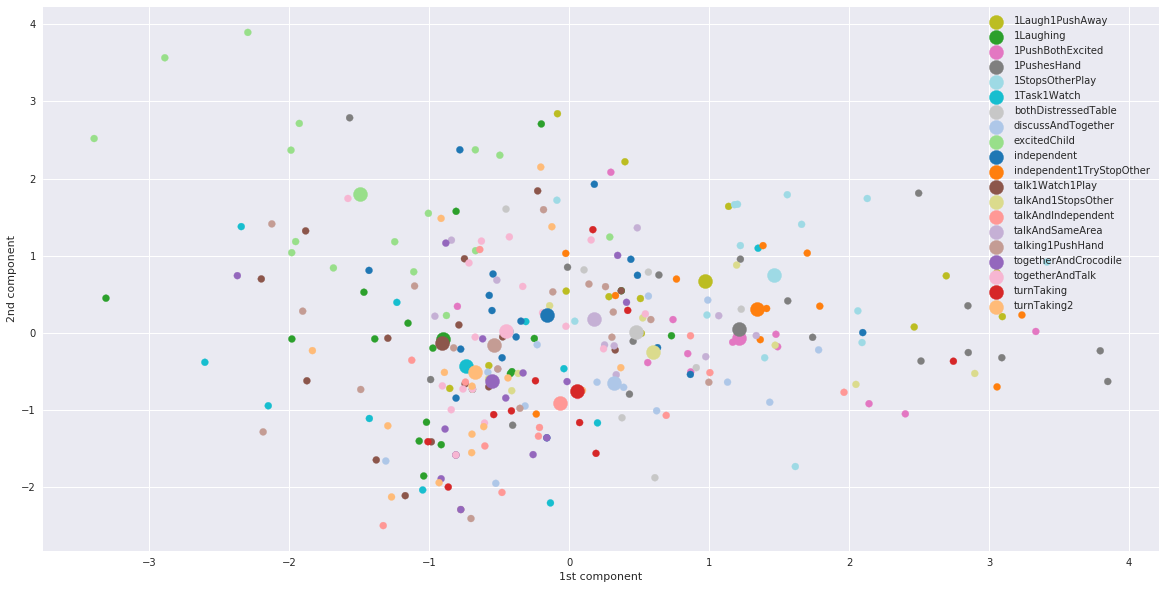

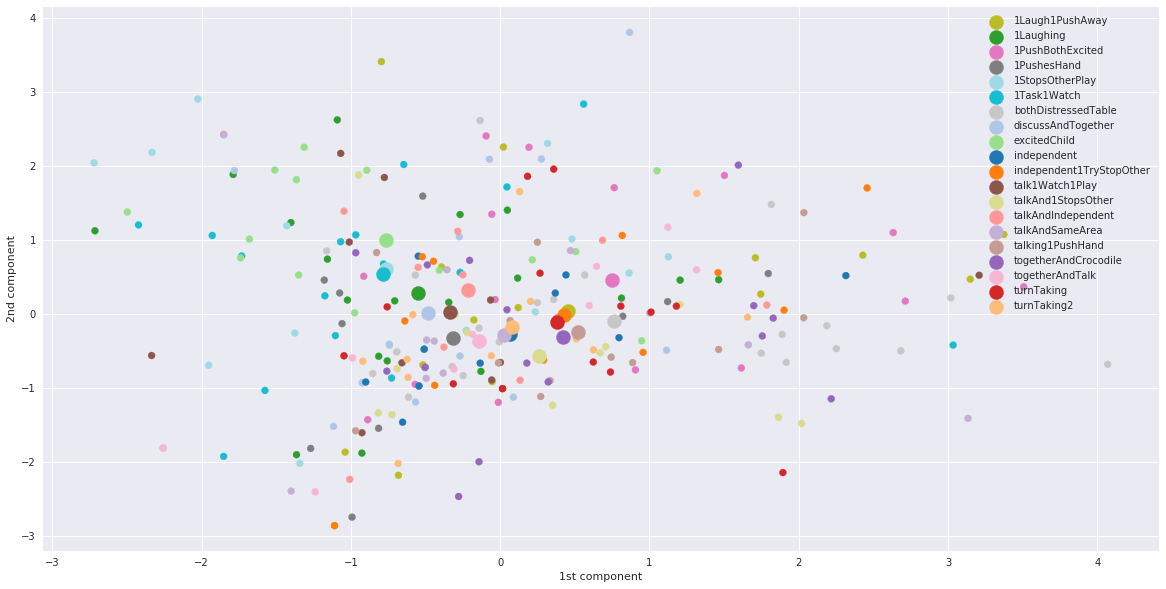

In [15]:
plot_embedding(fullscene_lda, fullscene_labels,fullscene_means_lda, fullscene_means.index, three_d=False)
plot_embedding(skel_lda, skel_labels,skel_means_lda, skel_means.index, three_d=False)

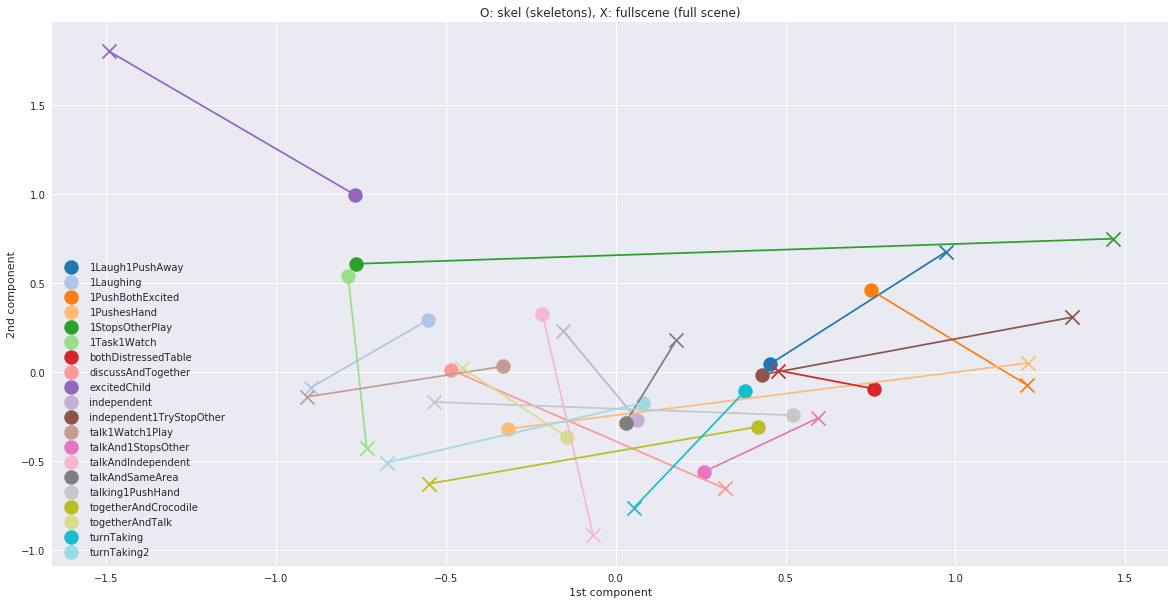

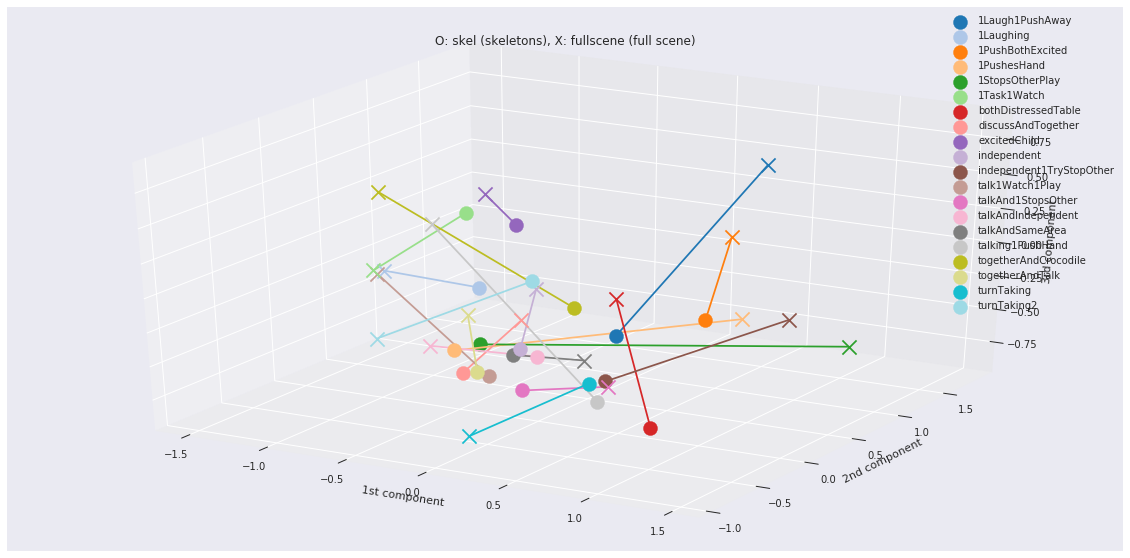

In [16]:
plot_compare_embeddings(skel_means_lda, fullscene_means_lda, fullscene_means.index,three_d=False)
plot_compare_embeddings(skel_means_lda, fullscene_means_lda, skel_means.index,three_d=True)

To answer the question: *does a PCA evidence common latent factors between our 2 conditions?*, we can again create a new LDA model for the skeletal data, and print out the LDA components for *fullscene* vs *skeleton* side-by-side.

We observe that they still look very different.

In [17]:
# compute as well a LDA model from the skeletal PCA to compare components with fullscene
skel_lda_model = LinearDiscriminantAnalysis(n_components=nb_components, solver='svd')
skel_lda_model.fit(skel_pca, skel_labels)


fullscene_lda_components = pd.DataFrame(fullscene_lda_model.scalings_.T).T
skel_lda_components = pd.DataFrame(skel_lda_model.scalings_.T).T

# merge PCA components into one dataframe, skel and fullscene side-by-side
lda_components=pd.concat([fullscene_lda_components, skel_lda_components], keys=["fullscene", "skel"], axis=1)
lda_components=lda_components.swaplevel(0,1,1).sort_index(1)

show_heatmap(lda_components[abs(lda_components)>0.2])

/usr/lib/python3/dist-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


## Explorative Factor Analysis

The Python [factor_analyzer](https://factor-analyzer.readthedocs.io) module is a port of EFA from the R' `psych` package.

In [18]:
import factor_analyzer

rotation = None

nb_factors=5

fa_skel = factor_analyzer.FactorAnalyzer()
fa_skel.analyze(skel_ratings_df, nb_factors, rotation=rotation)
skel_loadings=fa_skel.loadings

fa_fullscene = factor_analyzer.FactorAnalyzer()
fa_fullscene.analyze(fullscene_ratings_df, nb_factors, rotation=rotation)
fullscene_loadings=fa_fullscene.loadings

Comparing the loadings for the *fullscene* vs the *skeletal* only data show that the first two factors are highly correlated. **This shows that, using factor analysis, we have uncovered latent constructs that are used by participants to describe the clips in both *fullscene* and *skeletal-only* conditions**.

In [19]:
# merge loadings into one dataframe, skel and fullscene side-by-side
loadings=pd.concat([fullscene_loadings, skel_loadings], keys=["fullscene","skel"], axis=1)
loadings=loadings.swaplevel(0,1,1).sort_index(1)

from scipy.stats import pearsonr

print("Pearson correlation between factors 'fullscene' vs 'skeletal'")
for i in range(1, nb_factors+1):
    r, p=pearsonr(loadings["Factor%d" % i]["fullscene"].values, loadings["Factor%d" % i]["skel"].values)
    print("Factor %d: r=%f, p=%f" % (i,r,p)) 
    
    
show_heatmap(loadings[abs(loadings)>=0.35])

Pearson correlation between factors 'fullscene' vs 'skeletal'
Factor 1: r=0.976565, p=0.000000
Factor 2: r=0.760026, p=0.000041
Factor 3: r=0.377883, p=0.082931
Factor 4: r=0.893846, p=0.000000
Factor 5: r=-0.811945, p=0.000004


/usr/lib/python3/dist-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


In [20]:
fa_skel.get_factor_variance()


,Factor1,Factor2,Factor3,Factor4,Factor5
SS Loadings,5.776372,2.434673,1.806547,0.961065,0.872110
Proportion Var,0.262562,0.110667,0.082116,0.043685,0.039641
Cumulative Var,0.262562,0.373229,0.455345,0.499030,0.538671


In [21]:
fa_fullscene.get_factor_variance()

,Factor1,Factor2,Factor3,Factor4,Factor5
SS Loadings,5.076255,2.978365,2.066465,1.042835,0.827686
Proportion Var,0.230739,0.135380,0.093930,0.047402,0.037622
Cumulative Var,0.230739,0.366119,0.460049,0.507451,0.545073


# Clustering

We can use the EFA space as a 'better' space to represent our clips, where the latent, composite constructs correspond to the main axis:

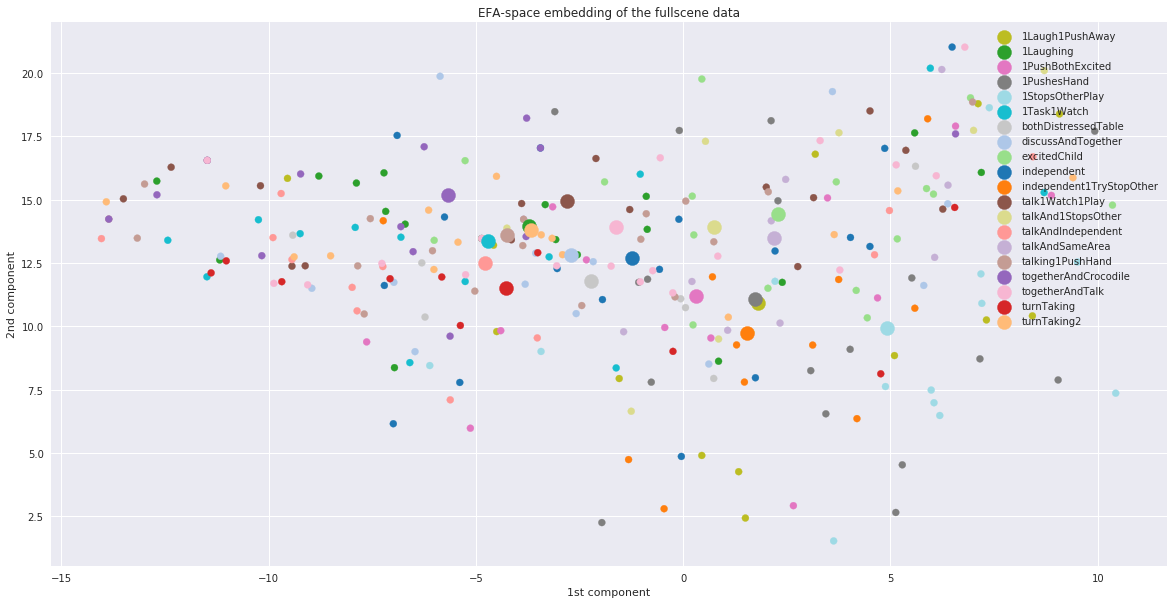

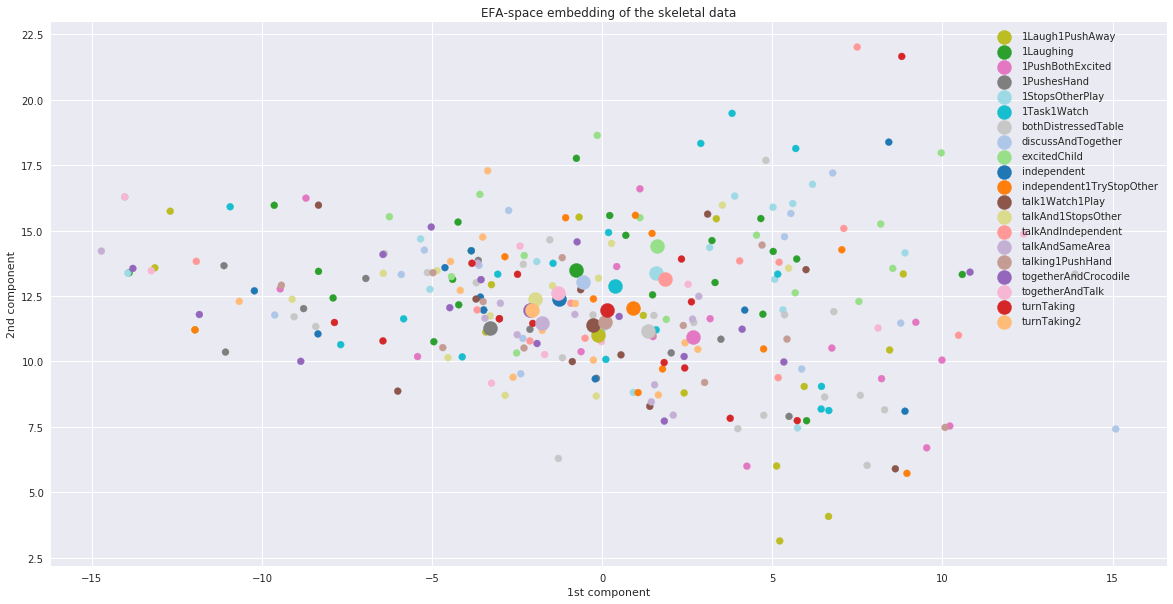

In [22]:
fullscene_efa = np.dot(fullscene,fullscene_loadings.values)
fullscene_means_efa = np.dot(fullscene_means,fullscene_loadings.values)
skel_efa = np.dot(skel,fullscene_loadings.values)
skel_means_efa = np.dot(skel_means,fullscene_loadings.values)

plot_embedding(fullscene_efa, fullscene_labels,fullscene_means_efa, fullscene_means.index, title="EFA-space embedding of the fullscene data", three_d=False)
plot_embedding(skel_efa, skel_labels,skel_means_efa, skel_means.index, title="EFA-space embedding of the skeletal data", three_d=False)


We can then attempt to cluster our 20 clips into 'groups' of similar clips (based on the latent constructs):

,cluster #
clipName,
1Laugh1PushAway,0
1PushBothExcited,0
1PushesHand,0
1StopsOtherPlay,0
talkAndSameArea,0
talkAnd1StopsOther,0
independent1TryStopOther,0
togetherAndCrocodile,1
talking1PushHand,1


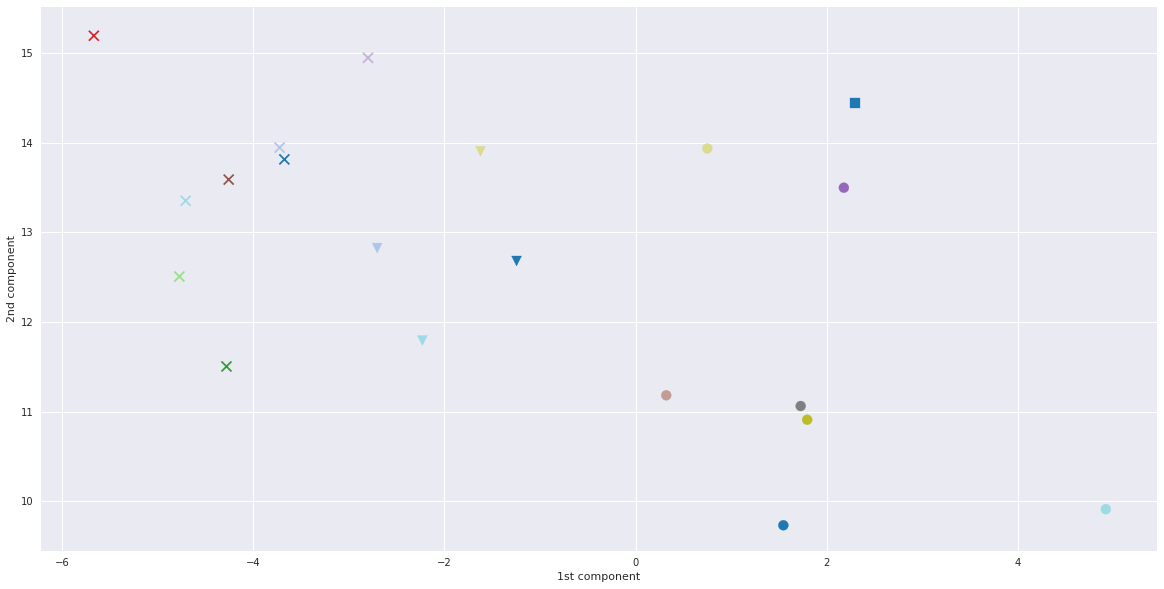

In [23]:
from sklearn.cluster import KMeans

# kMeans clustering after projecting our clips in the EFA-space
fullscene_clustering_data=fullscene_means_efa

nb_clusters=4

fullscene_kmeans_model = KMeans(n_clusters=nb_clusters, random_state=0).fit(fullscene_clustering_data)
fullscene_kmeans = fullscene_kmeans_model.predict(fullscene_clustering_data)

plot_embedding(fullscene_clustering_data,fullscene_means.index,clusters=fullscene_kmeans, three_d=False)

pd.DataFrame(fullscene_kmeans, index=fullscene_means.index, columns=["cluster #"]).sort_values(by="cluster #")

We can then try to predict in which cluster the clips would end up, using only the ratings from the skeletal videos:

7 skeleton clips out of 20 are predicted to fall into the same cluster as their 'fullscene' counterpart (35.0%)


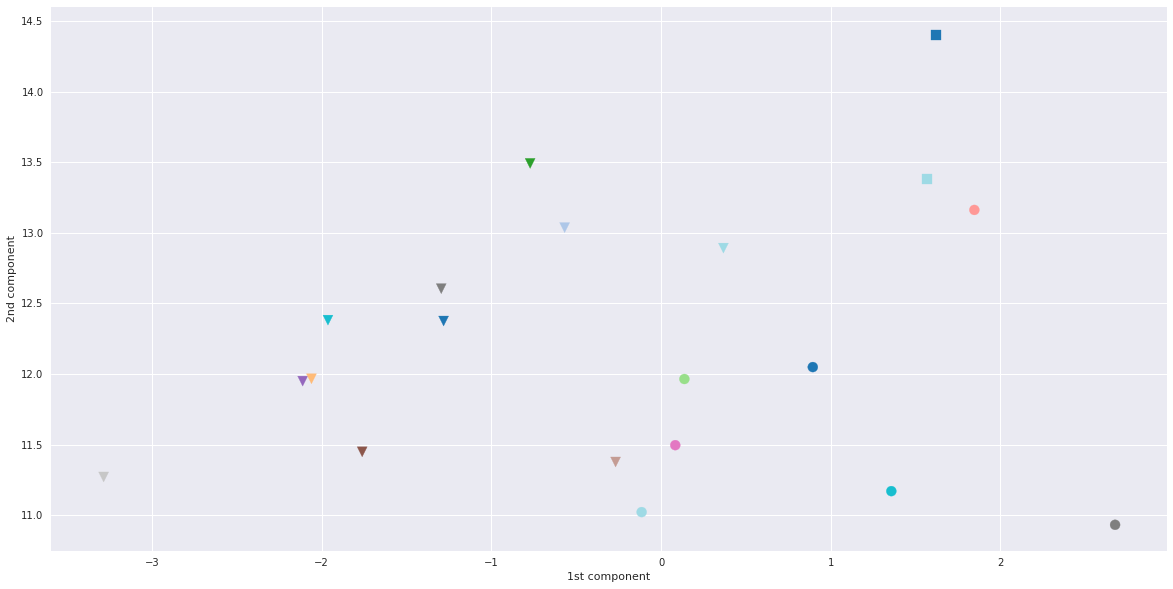

In [28]:
skel_kmeans= fullscene_kmeans_model.predict(skel_means_efa)

plot_embedding(skel_means_efa,skel_means.index, clusters=skel_kmeans, three_d=False)

diff=pd.DataFrame(fullscene_kmeans-skel_kmeans,index=skel_means.index)
print("%d skeleton clips out of %d are predicted to fall into the same cluster as their 'fullscene' counterpart (%.1f%%)" % (diff[diff==0].count(), skel_kmeans.size, diff[diff==0].count() * 100. / skel_kmeans.size))

# Classification

Using a SVM classifier, we can try to improve our predictions

In [25]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')

# trying with skel, skel_pca, skel_lda do not lead to any clear improvements
training_set = fullscene_means_efa
training_labels = fullscene_kmeans

testing_set = skel_means_efa
# Critically, we are testing with the *fullscene_kmeans* as we want to check whether 
# we predict the same clusters as with the fullscene stimuli.
testing_labels = fullscene_kmeans

clf.fit(training_set, training_labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [26]:
for p, l in zip(clf.predict(testing_set), testing_labels):
    print("%s (should be %s)" % (p,l))
print("SVM: %.1f%% successful prediction out of %d tested clips" % (clf.score(testing_set, testing_labels) * 100, len(testing_labels)))

0 (should be 0)
3 (should be 1)
0 (should be 0)
1 (should be 0)
0 (should be 0)
0 (should be 1)
0 (should be 3)
3 (should be 3)
0 (should be 2)
3 (should be 3)
0 (should be 0)
0 (should be 1)
3 (should be 0)
0 (should be 1)
3 (should be 0)
0 (should be 1)
3 (should be 1)
3 (should be 3)
0 (should be 1)
3 (should be 1)
SVM: 35.0% successful prediction out of 20 tested clips


Confusion matrix, without normalization


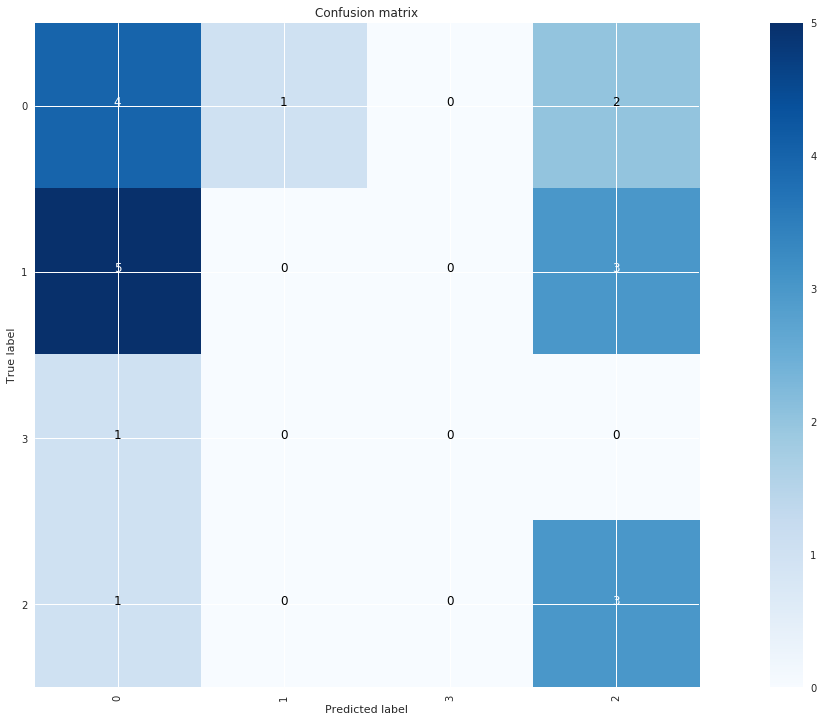

In [27]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(testing_labels, clf.predict(testing_set))
plot_confusion_matrix(cnf_matrix, classes=pd.unique(testing_labels))